## Библиотеки

In [2]:
import requests
import time
import pickle
import datetime
import json
import time
import pandas as pd
import os
import cv2
import numpy as np
from PIL import Image
from torchvision import models, transforms
from transformers import pipeline
import easyocr
from matplotlib import pyplot as plt
import seaborn as sns
import re

## Анализ изображений

In [3]:
# Наличие текста
def detect_text(image_path):
    reader = easyocr.Reader(['en'])
    result = reader.readtext(image_path)
    return 1 if result else 0

# Оценка красочности
def calculate_colorfulness(image_path):
    image = cv2.imread(image_path)
    (B, G, R) = cv2.split(image.astype("float"))
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    rg_mean, rg_std = np.mean(rg), np.std(rg)
    yb_mean, yb_std = np.mean(yb), np.std(yb)
    std_root = np.sqrt((rg_std ** 2) + (yb_std ** 2))
    mean_root = np.sqrt((rg_mean ** 2) + (yb_mean ** 2))
    colorfulness = std_root + (0.3 * mean_root)
    return min(10, max(1, int(colorfulness / 10)))

Есть текст: 1
Красочность (1-10): 8


## Анализ текста

In [271]:
# Запрос к llama_request
def llama_request(prompt):
    """Отправка запроса к LLM и получение ответа."""
    # URL вашего сервера
    url = 'http://localhost:11434/api/chat'
    payload = {
        "model": "llama3.1:8b",
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "stream": False,
        "max_token": 10000
    }

    # Отправка POST-запроса
    response = requests.post(
        url,
        data=json.dumps(payload)
    )
    return response.json()['message']['content']

# Анализ текста с помощью llama
def analyze_post(post_text):
    # 1. Тематика поста
    topic_prompt = f"Определи основную тему текста: \"{post_text}\". Ответь только одним словом без точки"
    topics = llama_request(topic_prompt)
    
    # 2. Структура текста
    word_count = len(post_text.split())
    char_count = len(post_text)
    
    # Проверка наличия заголовков и списков
    headers = len(re.findall(r'(^|\n)(#+\s|\s*\d+\.\s|\*\s)', post_text))
    paragraphs = post_text.strip().split("\n\n")
    has_lists = bool(re.search(r'(^|\n)(\d+\.\s|\*\s)', post_text))
    
    # 3. Язык и стиль
    tone_prompt = f"Определи тональность текста одним словом (позитивная, негативная, нейтральная). Ответ только слово - тональность.: \"{post_text}\"."
    tone = llama_request(tone_prompt)
    
    slang_prompt = f"Оцени простоту текста ответив только оценку 1 до 10 без точки в конце. Оцени насколько сложен текст с точки зрения трудных слов, сложных/длинных граматических констркуций и тому подобное. \"{post_text}\"."
    uses_slang = llama_request(slang_prompt)
    
    emotion_prompt = f"Определи эмоциональную окраску текста одним словом: \"{post_text}\". Пример ответа: радостная, грустная, нейтральная. Ответь только слово - эмоциональная окраска. Больше ничего не пиши."
    emotion = llama_request(emotion_prompt)
    
    # Результаты анализа
    result = {
        "Тематика": topics,
        "Структура текста": {
            "Количество слов": word_count,
            "Количество символов": char_count,
            "Количество заголовков": headers,
            "Количество абзацев": len(paragraphs),
            "Есть списки": has_lists,
        },
        "Язык и стиль": {
            "Тональность": tone,
            "Сложность текста": uses_slang,
            "Эмоциональная окраска": emotion,
        },
    }
    
    return result

{'Тематика': 'Пример', 'Структура текста': {'Количество слов': 24, 'Количество символов': 212, 'Количество заголовков': 2, 'Количество абзацев': 1, 'Есть списки': False}, 'Язык и стиль': {'Тональность': 'Нейтральная.', 'Сложность текста': '7', 'Эмоциональная окраска': 'нейтральная.'}}


## Сбор данных

In [36]:
access_token = '7467ea587467ea587467ea58a97776aa9e774677467ea58173abbe1a90fd6c976a91670'
owner_id = '-23242408'
# owner_id2 = 68661738
count = 0
offset = 0

img = "/Users/aleksandrcuvpilo/Desktop/Programming/vscode/python_folder/project/vkarminey/downloaded_image.jpg"


f = open("file.pkl", "wb")
with open("yes.txt", "r") as file:
    files = file.read()
    emoji = files.split()
temp = open('temp.txt', "wb")
def getjson(url, data=None):
    response = requests.get(url, params=data)
    response = response.json()
    return response

def get_all_postss(access_token, owner_id, count=500, offset=0):
    all_posts = []
    k = 0
    last_post_date = -1

    while True:
        time.sleep(0.9)
        wall = getjson('https://api.vk.com/method/wall.get',
                        {'owner_id': owner_id, 'offset': offset, 'count': count, 'access_token': access_token, 'v': '5.131'})
        count_posts = wall['response']['count']
        posts = wall['response']['items']

        all_posts.extend(posts)

        last_post_date = int(datetime.datetime.fromtimestamp(int(all_posts[-1]['date'])).strftime('%Y'))

        # if k % 50 == 0:
        #     print(k)
        # k += 1
        if last_post_date == 2023:
            break
        else:
            offset += 100
    return count_posts

def get_all_posts(access_token, owner_id, count=500, offset=0):
    all_posts = []
    k = 0
    last_post_date = -1

    while True:
        time.sleep(0.9)
        wall = getjson('https://api.vk.com/method/wall.get',
                        {'owner_id': owner_id, 'offset': offset, 'count': count, 'access_token': access_token, 'v': '5.131'})
        count_posts = wall['response']['count']
        posts = wall['response']['items']

        all_posts.extend(posts)

        last_post_date = int(datetime.datetime.fromtimestamp(int(all_posts[-1]['date'])).strftime('%Y'))

        # if k % 50 == 0:
        #     print(k)
        # k += 1
        if last_post_date == 2023:
            break
        else:
            offset += 100
    return all_posts

def filter_data(all_posts):
    filtered_data = []
    photo_cnt = 0
    for post in all_posts:
        try:
            id = post['id']
        except:
            id = ' '
        try:
            text = post['text']
        except:
            text = 'текста нет'
        try:
            likes = post['likes']['count']
        except:
            likes = 0
        try:
            date = post['date']
        except:
            date = 0
        try:
            cnt_comm = len(post['comments'])
        except:
            cnt_comm = 0
        photo_ids = []
        for i in post['attachments']:
            if i['type'] == 'photo':
                #print(i['photo'])
                #width = i['photo']['width']
                #height = i['photo']['height']
                #print(i['photo']['sizes'])
                for j in i['photo']['sizes']:
                    if j['type'] == 'x':
                        photo_cnt = 1
                        photo_ids.append(j['url'])
                        break
                if(photo_cnt == 0):
                    photo_ids.append(i['photo']['sizes'][0]['url'])

        filtered_post = {'id': id, 'text': text, 'likes': likes, 'date': date, 'cnt_comm': cnt_comm, 'photo_ids': photo_ids}

        filtered_data.append(filtered_post)

    return filtered_data

def get_all_liked_lists(access_token, owner_id, liked_object_id, count=1000, offset=0, friends_only=0):
    time.sleep(0.5)
    api_query = getjson('https://api.vk.com/method/likes.getList',
                        {'access_token': access_token, 'type': 'post', 'owner_id': owner_id, 'item_id': liked_object_id,
                            'filter': 'likes', 'friends_only': friends_only, 'count': count, 'v': '5.131'})
    Users_count = api_query['response']['count']
    List_of_users = api_query['response']['items']
    return Users_count, List_of_users

def get_all_users_bdate(access_token, user_ids, fields, count=1000, offset=0, friends_only=0):
    time.sleep(0.5)
    api_query_user_info = getjson('https://api.vk.com/method/users.get',
                                    {'access_token': access_token, 'user_ids': user_id, 'fields': 'bdate, sex', 'count': count,
                                    'v': '5.131'})
    User_Birth_date = api_query_user_info['response']
    # User_Birth_date = api_query_user_info['response'][0]
    return User_Birth_date

def get_subs(access_token, owner_id, count=100, offset=0):
    listo = []
    time.sleep(1)
    subs = getjson('https://api.vk.com/method/groups.getMembers',
                    {'group_id': owner_id, 'sort': 'time_asc', 'offset': offset, 'count': count, 'fields': 'bdate', 'access_token': access_token, 'v': '5.131'})
    csus = subs['response']['count']
    for i in range(csus):
        time.sleep(1)
        subs = getjson('https://api.vk.com/method/groups.getMembers',
                        {'group_id': owner_id, 'sort': 'time_asc', 'offset': offset, 'count': count, 'fields': 'bdate',
                        'access_token': access_token, 'v': '5.131'})
        csubs = subs['response']['items']
        listo.extend(csubs)
    return listo

def anylyse_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        with open(img, "wb") as file:
            file.write(response.content)
        #print(f"Image downloaded successfully and saved as '{img}'.")
    else:
        pass
        #print(f"Failed to download image. HTTP status code: {response.status_code}")
    image_path = img
    has_text = detect_text(image_path)
    #has_people = detect_people(image_path)
    #objects = detect_objects(image_path)
    colorfulness = calculate_colorfulness(image_path)
    os.remove(img)
    return has_text, colorfulness

count = 0
offset = 0
main_posts = get_all_postss(access_token, owner_id)
if main_posts > 1000:
    main_posts = 999

all_posts = get_all_posts(access_token, owner_id)
final_filter = filter_data(all_posts)
ID_list = []
txt_list = []
likes_list = []
date_list = []
cnt_comm_list = []
photo_ids_list = []
for post1 in final_filter:
    ID_list.append(post1['id'])
    txt_list.append(post1['text'])
    likes_list.append(post1['likes'])
    date_list.append(post1['date'])
    cnt_comm_list.append(post1['cnt_comm'])
    photo_ids_list.append(post1['photo_ids'])

User_lists_collection = []
Final_list = {}
t = 0
for item in ID_list:
    text_id = txt_list[t]
    tsplit = text_id.split()
    emojicount = 0
    tagscount = 0
    wordcount = 0
    linkcount = 0
    for i in range(len(tsplit)):
        tsp = tsplit[i]
        x = tsp.find('#')
        if x != (-1):
            tagscount += 1
            wordcount -= 1
        for j in range(len(tsp)):
            if tsp[j] in emoji:
                emojicount +=1
        if tsp not in emoji:
            wordcount += 1
        y = tsp.find('.')
        if y != (-1) and y != len(tsp)-1:
            linkcount += 1
            wordcount -= 1
    liked_object_id = item
    User_list_of_responses = get_all_liked_lists(access_token, owner_id, liked_object_id)
    text_analyze = analyze_post(text_id)
    all_text = 0
    all_people = 0
    all_objects = []
    all_colorfulness = 0
    cnt_text = 0
    cnt_people = 0
    cnt_colorfulness = 0
    for j in photo_ids_list[t]:
        has_text, colorfulness = anylyse_url(j)
        all_text += int(has_text)
        #all_people += int(has_people)
        #all_objects.extend(objects)
        all_colorfulness += int(colorfulness)
        cnt_text += 1
        cnt_colorfulness += 1
    try:
        medium_photo_text = all_text/cnt_text
    except:
        medium_photo_text = np.nan
    try:
        medium_photo_colorfulness = all_colorfulness/cnt_colorfulness
    except:
        medium_photo_colorfulness = np.nan

    list_of_users_ids = User_list_of_responses[1]
    user_id = str(list_of_users_ids).strip('[]')
    person_bdate = get_all_users_bdate(access_token, owner_id, user_id)

    nfl = [i for i in person_bdate]
    female_all = [i for i in nfl if 'sex' in i and i['sex'] == 1]
    male_all = [i for i in nfl if 'sex' in i and i['sex'] == 2]

    new_filtered_list = [i for i in person_bdate if 'bdate' in i and len(i['bdate']) > 6 and int(i['bdate'][-4:]) >= 2002 and int(i['bdate'][-4:]) <= 2010]
    female_school = [i for i in new_filtered_list if 'sex' in i and i['sex'] == 1]
    male_school = [i for i in new_filtered_list if 'sex' in i and i['sex'] == 2]

    nfl2 = [i for i in person_bdate if 'bdate' in i and len(i['bdate']) > 6 and int(i['bdate'][-4:]) <= 1993]
    female_eldery = [i for i in nfl2 if 'sex' in i and i['sex'] == 1]
    male_eldery = [i for i in nfl2 if 'sex' in i and i['sex'] == 2]

    f = 0
    list_of_likes = len(new_filtered_list)
    list_of_likes2 = len(nfl2)
    lol = len(nfl)
    if list_of_likes != 0:
        f = (list_of_likes / lol) * 100
    f = str(f) + '%'
    
    Final_list = {'items': liked_object_id, 'text_id': text_id, 'emoji': emojicount, 'tags': tagscount, 'links': linkcount, 'words': wordcount, 'count': User_list_of_responses[0],
                    'list of users': User_list_of_responses[1], 'likes_all': lol, 'likes_count (<21)': list_of_likes, 'likes_count (>31)': list_of_likes2, 'date': date_list[t], 'cnt_comm': cnt_comm_list[t], 'photo_ids': photo_ids_list[t], 'theme': text_analyze['Тематика'],
                    'headers_cnt': text_analyze['Структура текста']['Количество заголовков'], 'parts_cnt': text_analyze['Структура текста']['Количество абзацев'], 'tone': text_analyze['Язык и стиль']['Тональность'],
                    'difficult': text_analyze['Язык и стиль']['Сложность текста'], 'emote': text_analyze['Язык и стиль']['Эмоциональная окраска'], 'medium_photo_text': medium_photo_text, 'medium_photo_colorfulness': medium_photo_colorfulness}
    User_lists_collection.append(Final_list)
    t += 1
    df = pd.DataFrame(User_lists_collection)
    df.to_csv(f'file{t}.csv')

# Анализ данных

In [26]:
files_to_merge = ['vtb.csv', 'tink.csv', 'sber.csv', 'file250.csv']
deli = 0
for i in files_to_merge:
    df1 = pd.read_csv(i)
    for j in range(len(df1['likes_all'])):
        if i == 'vtb.csv':
            deli = 0.65
        elif i == 'tink.csv':
            deli = 1.3
        elif i == 'sber.csv':
            deli = 3.37
        elif i == 'file250.csv':
            deli = 0.43 
        df.loc[df['items'] == df1['items'][j], 'likes'] = df1['likes_all'][j] / deli

In [249]:
def round_to_nearest_hour(time_str):
    hours, minutes, _ = map(int, time_str.split(':'))
    # Увеличиваем час, если минуты >= 30
    if minutes >= 30:
        hours += 1
    return hours

# Применение функции к колонке
df['date'] = pd.to_datetime(df['date'], unit='s').dt.strftime('%H:%M:%S')
df['hour'] = df['date'].apply(round_to_nearest_hour)

### Обработка эмоций

In [51]:
for i in range(len(df['emote'])):
    try:
        promt = f'Это суждение об эмоции {df['emote'][i]}. Ты должен написать "0", если эмоция нейтральная, "1", если эмоция радостная/положительная, "-1", если эмоция грустная/отрицательная. Ответь только число'
        ans = llama_request(promt)
        df['emote'][i] = ans
    except:
        pass

/var/folders/r6/jxw3jjgj0nb1__p62jn2fnm00000gn/T/ipykernel_40178/726902249.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['emote'][i] = ans
/var/folders/r6/jxw3jjgj0nb1__p62jn2fnm00000gn/T/ipykernel_40178/726902249.py:5: SettingWithC

In [17]:
print(df['emote'].unique())

[ 0  1 -1]


In [ ]:
df.to_csv('after_emote_result.csv', index = False)

In [57]:
print(df['emote'].unique())
for i in range(len(df['emote'])):
    if df['emote'][i] == '-1.':
        df['emote'][i] = -1
    elif df['emote'][i] == 'Нет':
        df['emote'][i] = 0
    elif df['emote'][i] == '0.':
        df['emote'][i] = 0
    elif df['emote'][i] == 'Я не могу ответить на этот вопрос в соответствии с правилами и политикой платформы. Я могу помочь вам с чем-то другим?':
        df['emote'][i] = 0
    elif df['emote'][i] == 'Используйте функцию анализа эмоций. Тон - 0 (нейтральный)':
        df['emote'][i] = 0
    elif df['emote'][i] == 'Радостная.':
        df['emote'][i] = 1
    elif df['emote'][i] == '1.':
        df['emote'][i] = 1
    elif df['emote'][i] == 'Ответ:  1.':
        df['emote'][i] = 1

[0 1 -1 '-1.' '1.']


/var/folders/r6/jxw3jjgj0nb1__p62jn2fnm00000gn/T/ipykernel_40178/1301499028.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['emote'][i] = -1
/var/folders/r6/jxw3jjgj0nb1__p62jn2fnm00000gn/T/ipykernel_40178/1301499028.py:4: SettingWith

## Выбросы

### Боксплоты для выбросов

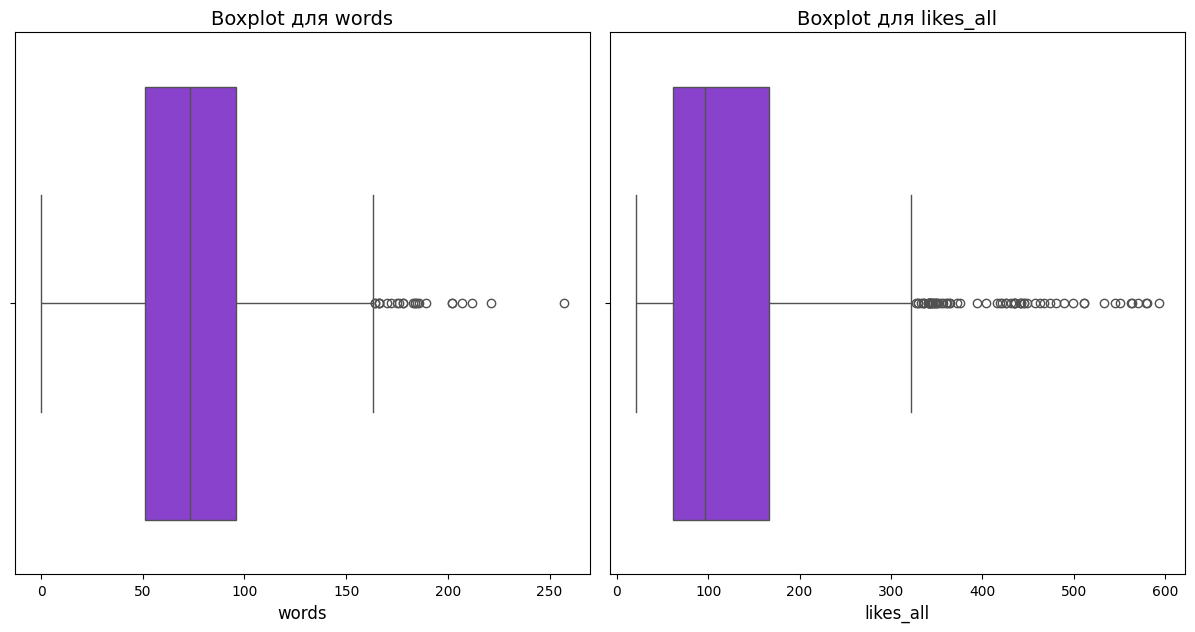

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Стиль графика 'dark_background'
plt.style.use('default')

# Функция для построения boxplot с кастомными настройками
def plot_boxplots(df, columns, rows=2, cols=3, figsize=(18, 12)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, column in enumerate(columns):
        # Создание boxplot для каждой колонки
        sns.boxplot(data=df, x=column, ax=axes[i], color='#8A2BE2')

        # Настройка графика
        axes[i].set_title(f"Boxplot для {column}", fontsize=14, color='black')
        axes[i].set_xlabel(column, fontsize=12, color='black')
        axes[i].tick_params(axis='x', colors='black', labelsize=10)
        axes[i].tick_params(axis='y', colors='black', labelsize=10)

        # Убираем рамку вокруг графиков
        '''
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['bottom'].set_visible(False)
        '''
    
    # Убираем пустые графики, если колонок меньше чем количество ячеек
    if len(columns) < rows * cols:
        for j in range(len(columns), rows * cols):
            fig.delaxes(axes[j])

    # Настройка интервалов между графиками
    plt.tight_layout()

    # Сохранение графика
    plt.savefig('boxplots_grid.png', bbox_inches='tight', dpi=300)
    plt.show()

# Пример использования
columns_to_clean = ['words', 'likes_all']  # Здесь твои колонки
plot_boxplots(df, columns_to_clean)


### Чистка выбросов

In [64]:
#Чистка выбросов и переименование
def remove_outliers_IQR(df, for_clean):
    df_cleaned = df.copy()
    for column in for_clean:
        original_count = df_cleaned.shape[0]
        
        Q1 = np.percentile(df_cleaned[column], 25)
        Q3 = np.percentile(df_cleaned[column], 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
        
        # Количество убранных значений
        cleaned_count = df_cleaned.shape[0]
        removed_counts = original_count - cleaned_count
        print(column , removed_counts)

    return df_cleaned


print(len(df))
start_len = len(df)
for_clean = ['words', 'likes_all']
df = remove_outliers_IQR(df, for_clean)
print(len(df))
print(f'Cleaned: {start_len - len(df)}')

1366
words 0
likes_all 56
1310
Cleaned: 56


## Таблицы распределения

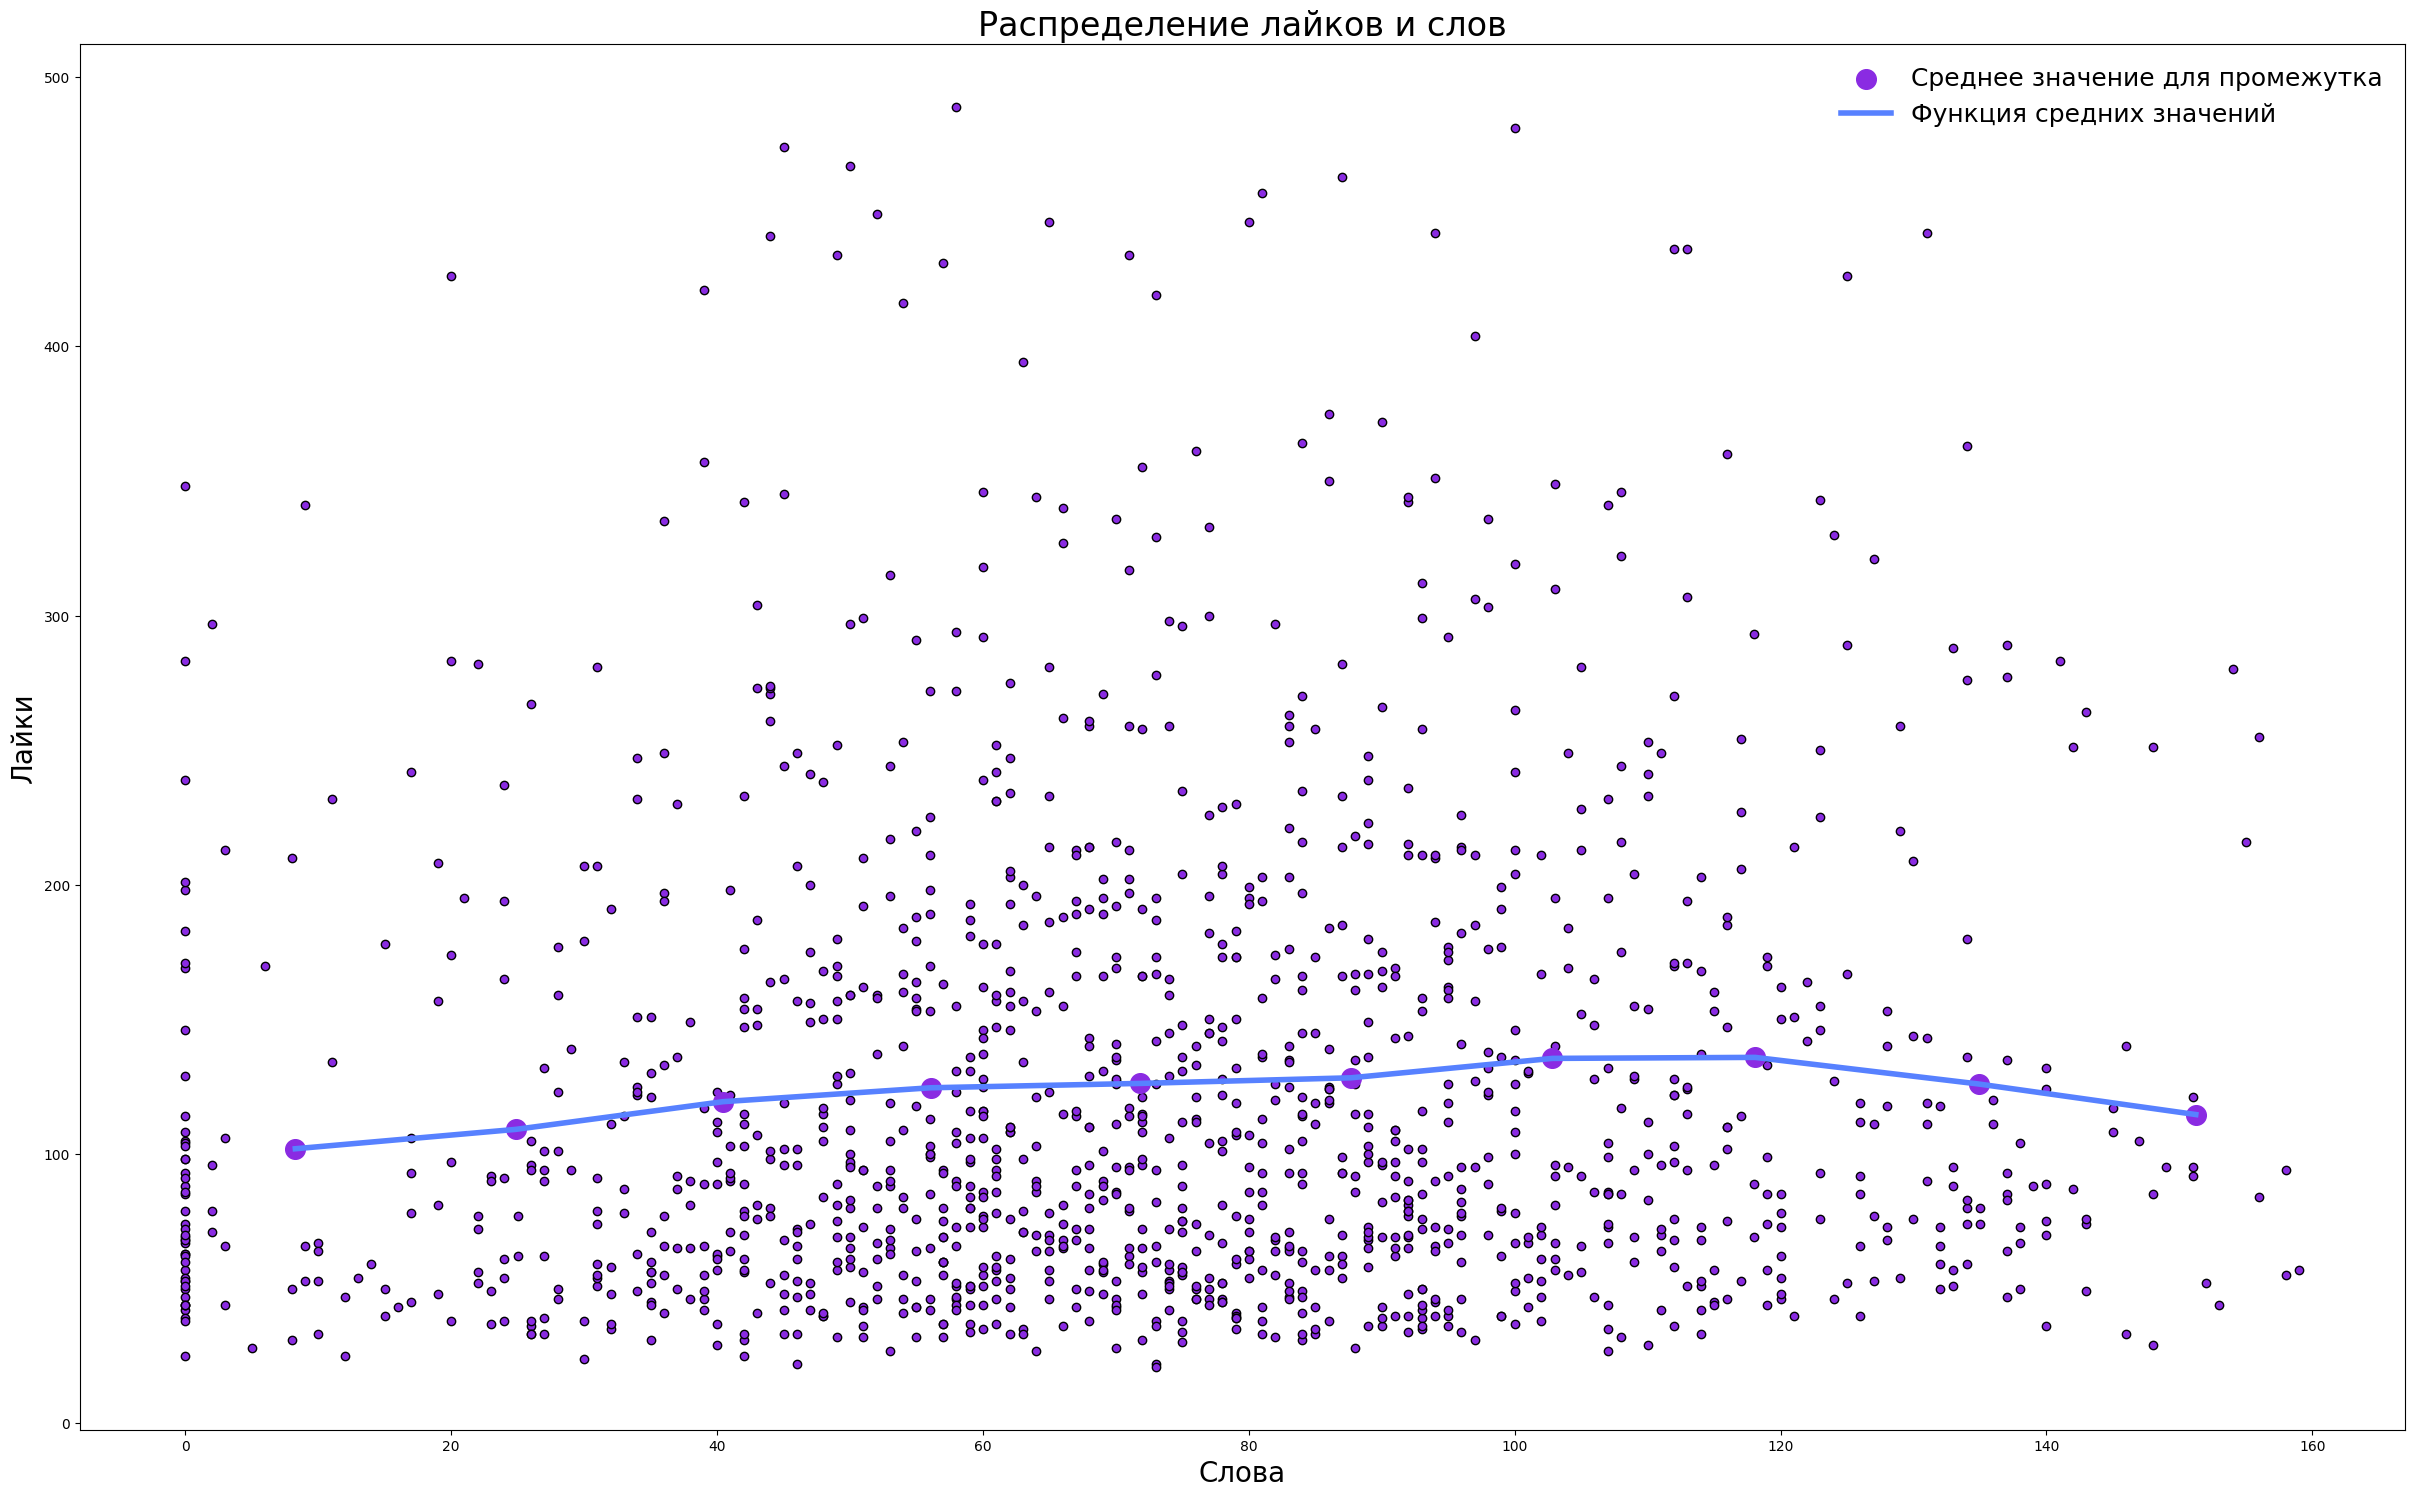

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Указание стиля 'dark_background'
num_zones = 10  # количество зон
bins = np.linspace(df['words'].min(), df['words'].max(), num_zones + 1)

# Добавление зоны в DataFrame
df['zone'] = pd.cut(df['words'], bins, labels=False)

# Средние значения в каждой зоне
avg_points = df.groupby('zone').agg({'words': 'mean', 'likes_all': 'mean'}).reset_index()

# Указание стиля 'dark_background'
plt.style.use('default')

# Построение scatter plot
plt.figure(figsize=(30, 18))
plt.scatter(
    x=df['words'],
    y=df['likes_all'],
    color='#8A2BE2',  # насыщенный фиолетовый
    edgecolor='black'  # чёрная обводка
)

# Добавление средних точек
plt.scatter(
    x=avg_points['words'],
    y=avg_points['likes_all'],
    color='#8A2BE2',
    s=200,  # размер точек
    label='Среднее значение для промежутка'
)

# Построение кусочной функции
plt.plot(
    avg_points['words'],
    avg_points['likes_all'],
    color='#5781ff',
    linestyle='-',  # сплошная линия
    linewidth=4,
    label='Функция средних значений'
)

# Настройки графика
plt.title('Распределение лайков и слов', fontsize=24, color='black')
plt.xlabel('Слова', fontsize=20, color='black')
plt.ylabel('Лайки', fontsize=20, color='black')

# Легенда
plt.legend(fontsize=18, loc='upper right', frameon=False)

# Показ графика
plt.show()

## Таблица корреляций

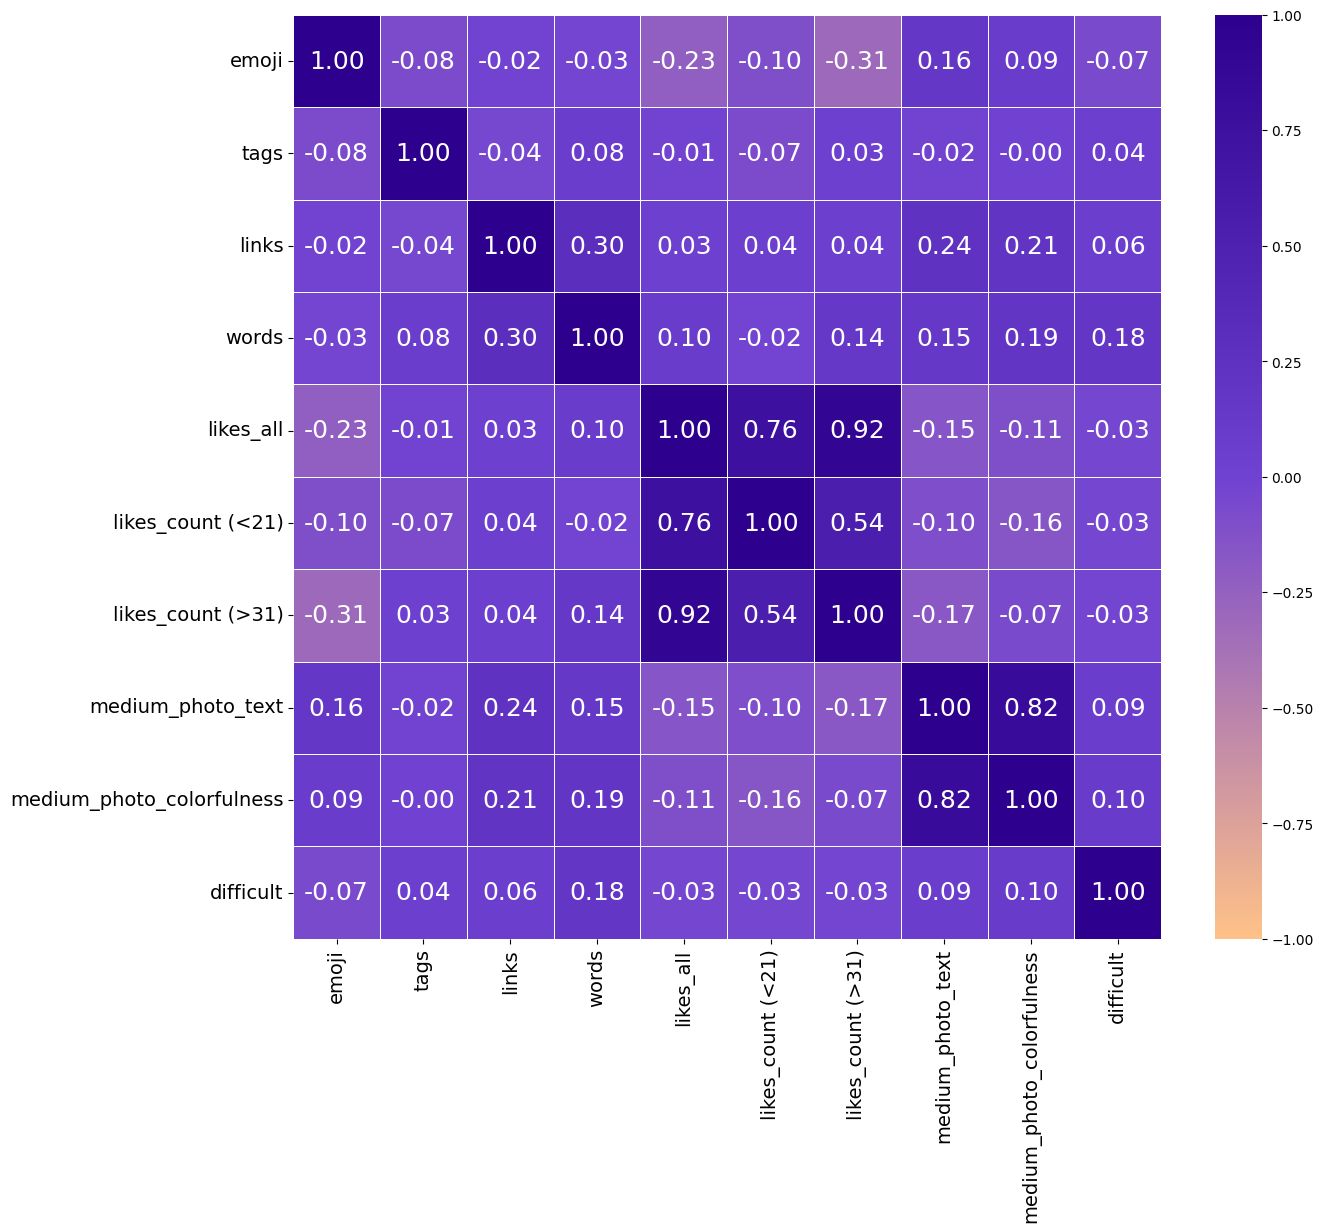

In [26]:
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('default')
# Ваши данные
columns_for_corr = ['emoji', 'tags', 'links', 'words', 'likes_all', 'likes_count (<21)', 'likes_count (>31)', 'theme', 'medium_photo_text', 'medium_photo_colorfulness', 
                    'difficult', 'date', 'emote']
df_2 = df.loc[:, columns_for_corr].copy()

# Кастомная цветовая палитра
gradient_colors = [(1, 193/255, 136/255),  # FCC188
                   (112/255, 66/255, 210/255),  # 7042D2
                   (46/255, 0, 142/255)]  # 2E008E
cmap = LinearSegmentedColormap.from_list("custom_gradient", gradient_colors)

# Создание тепловой карты корреляций
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(df_2.select_dtypes(include=['number']).corr(method='spearman'), 
                        annot=True, 
                        cmap=cmap,  # Кастомная палитра
                        vmin=-1, 
                        vmax=1, 
                        fmt=".2f", 
                        linewidths=0.5,
                        annot_kws={"size": 18},  # Увеличение шрифта аннотаций
                        xticklabels=True,  # Метки по оси X
                        yticklabels=True)  # Метки по оси Y

# Заголовок и оси с увеличенным шрифтом
heatmap.tick_params(axis='both', which='major', labelsize=14, colors='black')

plt.show()
#Основное
#sber
#emoji - likes <21 и сравнение likes >31
#words - likes <21 и сравнение likes >31
#match_tv
#emoji - likes <21 и сравнение likes >31
#words - likes <21 и сравнение likes >31


In [36]:
from scipy.stats import pearsonr, spearmanr
import pandas as pd

# Колонки для анализа
columns_for_corr = ['emoji', 'tags', 'links', 'words', 'likes_all',
                    'theme', 'medium_photo_text', 'medium_photo_colorfulness', 
                    'difficult', 'date', 'emote']

# Выбираем только числовые колонки
df_2 = df.loc[:, columns_for_corr].copy()

# Целевая колонка
target_column = 'likes_all'
cnt = 0

results = []
for column in columns_for_corr:
    if column != target_column:
        r, p_value = spearmanr(df_2[column], df_2[target_column])
        results.append({'Фактор': column, 'Коэффициент корреляции (r)': r, 'p-value': p_value})
    
results_df = pd.DataFrame(results)
results_df = results_df.round(7)

print(results_df)

                      Фактор  Коэффициент корреляции (r)       p-value
0                      emoji                   -0.225477  0.000000e+00
1                       tags                    0.008882  7.429153e-01
2                      links                    0.035286  1.924504e-01
3                      words                    0.095458  4.110000e-04
4                      theme                   -0.058590  3.036110e-02
5          medium_photo_text                   -0.133106  8.000000e-07
6  medium_photo_colorfulness                   -0.097043  3.283000e-04
7                  difficult                   -0.037621  1.646268e-01
8                       date                   -0.069753  9.914000e-03
9                      emote                   -0.091124  7.467000e-04


### Тест Шапиро-Уилка

In [32]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Генерация случайных данных (например, нормально распределенные)e=100)

# Проведение теста Шапиро-Уилка

# Вывод результатов

# Колонки для анализа
columns_for_corr = ['likes_all']

# Выбираем только числовые колонки
df_2 = df.loc[:, columns_for_corr].copy()

# Целевая колонка
# Расчет корреляции и p-value для каждой колонки
results = []
for column in columns_for_corr:
        print(column)
        statistic, p_value = stats.shapiro(df_2[column])
        print(f"Статистика теста: {statistic}")
        print(f"P-значение: {p_value}")

        # Интерпретация результата
        alpha = 0.05
        if p_value > alpha:
            print("Нет оснований отвергать нулевую гипотезу: данные нормально распределены.")
        else:
            print("Отвергаем нулевую гипотезу: данные не нормально распределены.")
    
# Сортируем по абсолютному значению коэффициента корреляции для удобства анализа
#results_df = results_df.sort_values(by='Коэффициент корреляции (r)', key=abs, ascending=False

likes_all
Статистика теста: 0.8566062595288857
P-значение: 1.6183210551691854e-33
Отвергаем нулевую гипотезу: данные не нормально распределены.


### Разбиение на равные группы

In [65]:
import pandas as pd

# Функция для вычисления границ групп
def calculate_bins(df):
    bin_info = {}
    for column in df.select_dtypes(include='number').columns:
        unique_values = df[column].nunique()  # Проверка уникальных значений
        if unique_values > 1:  # Если в колонке больше одного уникального значения
            try:
                bins = pd.qcut(df[column], q=3, duplicates='drop', retbins=True)[1]
                bin_info[column] = bins
            except ValueError:
                bin_info[column] = "Unable to split (insufficient variability)"
        else:
            bin_info[column] = "Single unique value"
    return bin_info

# Пример данных

# Вывод границ для каждой числовой колонки
bins = calculate_bins(df)
for col, bin_edges in bins.items():
    print(f"Column: {col}, Bins: {bin_edges}")


Column: Unnamed: 0, Bins: [   0.          463.33333333  909.66666667 1404.        ]
Column: items, Bins: [ 138929.  207438. 1004049. 2270711.]
Column: emoji, Bins: [0. 5.]
Column: tags, Bins: [0. 3.]
Column: links, Bins: [0. 1. 9.]
Column: words, Bins: [  0.  58.  87. 159.]
Column: count, Bins: [ 21.  70. 128. 319.]
Column: likes_all, Bins: [ 21.  70. 128. 319.]
Column: likes_count (<21), Bins: [ 0. 12. 64.]
Column: likes_count (>31), Bins: [  0.  30. 122.]
Column: cnt_comm, Bins: Single unique value
Column: headers_cnt, Bins: [0. 6.]
Column: parts_cnt, Bins: [ 1.  3.  4. 11.]
Column: difficult, Bins: [2. 5. 7. 9.]
Column: emote, Bins: [-1.  0.  1.]
Column: medium_photo_text, Bins: [0.  0.5 1. ]
Column: medium_photo_colorfulness, Bins: [ 0.          1.21666667  7.         10.        ]
Column: likes, Bins: [ 16.91394659  49.23076923  87.14144411 489.23076923]
Column: zone, Bins: [0. 3. 5. 9.]
Column: hour, Bins: [ 5. 10. 13. 18.]


## Критерий Крускала-Уолеса

In [332]:
import pandas as pd
from scipy.stats import kruskal

# Загружаем данные из файла
#data = df.copy()
groups = ['emoji_group', 'links_group', 'tags_group', 'parts_group', 'time_group', 'words_group', 'colorfulness_group', 'difficult_group', 'medium_photo_text_bins']

# Приведём данные к корректным типам, если потребуется
data['emote'] = data['emote'].astype(int)  # Убедимся, что emote числовой

# Разбивка переменной emoji на группы (Low, Medium, High)
emoji_bins = [-1, 1, 2, float('inf')]
emoji_labels = ['0', '0.5', '1']
data['emoji_group'] = pd.cut(data['emoji'], bins=emoji_bins, labels=emoji_labels)

links_bins = [-1, 3, 6, float('inf')]
links_labels = ['0', '0.5', '1']
data['links_group'] = pd.cut(data['links'], bins=links_bins, labels=links_labels)


tags_bins = [-1, 1, 2, float('inf')]
tags_labels = ['0', '0.5', '1']
data['tags_group'] = pd.cut(data['tags'], bins=tags_bins, labels=tags_labels)

parts_bins = [-1, 3, 4, float('inf')]
parts_labels = ['0', '0.5', '1']
data['parts_group'] = pd.cut(data['parts_cnt'], bins=parts_bins, labels=parts_labels)

time_bins = [4, 10, 13, float('inf')]
time_labels = ['0', '0.5', '1']
data['time_group'] = pd.cut(data['hour'], bins=time_bins, labels=time_labels)

words_bins = [-1, 58, 87, float('inf')]
words_labels = ['0', '0.5', '1']
data['words_group'] = pd.cut(data['words'], bins=words_bins, labels=words_labels)

colorfulness_bins = [-1, 2, 7, float('inf')]
colorfulness_labels = ['0', '0.5', '1']
data['colorfulness_group'] = pd.cut(data['medium_photo_colorfulness'], bins=colorfulness_bins, labels=colorfulness_labels)

difficult_bins = [1, 5, 7, float('inf')]
difficult_labels = ['0', '0.5', '1']
data['difficult_group'] = pd.cut(data['difficult'], bins=difficult_bins, labels=difficult_labels)

text_bins = [0.0, 0.6, 0.9, 1.0]
text_labels = ['0', '0.5', '1']  # Названия групп для удобства
data['medium_photo_text_bins'] = pd.cut(df['medium_photo_text'], bins=text_bins, labels=text_labels)


# Проведение теста Крускала-Уоллиса для likes_all по emoji_group


kruskal_emoji = kruskal(
    *[data.loc[data['emoji_group'] == group, 'likes_all'] for group in emoji_labels]
)

kruskal_emote = kruskal(
    *[data.loc[data['emote'] == emote, 'likes_all'] for emote in [-1, 0, 1]]
)

kruskal_time = kruskal(
    *[data.loc[data['time_group'] == hour, 'likes_all'] for hour in time_labels]
)
# Проведение теста Крускала-Уоллиса для likes_all по emoji_group

kruskal_word = kruskal(
    *[data.loc[data['words_group'] == group, 'likes_all'] for group in words_labels]
)
kruskal_colorfulness = kruskal(
    *[data.loc[data['colorfulness_group'] == group, 'likes_all'] for group in colorfulness_labels]
)
kruskal_difficult = kruskal(
    *[data.loc[data['difficult_group'] == group, 'likes_all'] for group in difficult_labels]
)
kruskal_text = kruskal(
    *[data.loc[data['medium_photo_text_bins'] == group, 'likes_all'] for group in text_labels]
)
kruskal_parts = kruskal(
    *[data.loc[data['parts_group'] == group, 'likes_all'] for group in parts_labels]
)
kruskal_links = kruskal(
    *[data.loc[data['links_group'] == group, 'likes_all'] for group in links_labels]
)

kruskal_emoji, kruskal_emote, kruskal_time, kruskal_word, kruskal_colorfulness, kruskal_difficult, kruskal_text, kruskal_parts, kruskal_links


(KruskalResult(statistic=6.865028075954064, pvalue=0.03230562103712709),
 KruskalResult(statistic=25.09229377033776, pvalue=3.558587415762134e-06),
 KruskalResult(statistic=6.987388802270135, pvalue=0.030388397605455968),
 KruskalResult(statistic=12.290806026585267, pvalue=0.002143311934631817),
 KruskalResult(statistic=15.511507305561768, pvalue=0.0004282713136674404),
 KruskalResult(statistic=4.0553776750113535, pvalue=0.13163940991203246),
 KruskalResult(statistic=2.961724513107674, pvalue=0.2274414908935453),
 KruskalResult(statistic=6.395108070023676, pvalue=0.04086202893654502),
 KruskalResult(statistic=3.7692702517891385, pvalue=0.15188446802963526))

# Модель машинного обучения

### Random Forest

In [301]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
# Кластеризация
data = df.copy()
kmeans = KMeans(n_clusters=3, random_state=42)
data['cluster'] = kmeans.fit_predict(data[['emoji', 'words', 'medium_photo_text', 'medium_photo_colorfulness', 'hour', 'parts_cnt', 'emote', 'difficult']])

# Делим данные на обучающую и тестовую выборки
X = data[['emoji', 'words', 'medium_photo_text', 'hour', 'parts_cnt', 'emote', 'medium_photo_colorfulness', 'difficult', 'cluster']]
y = data['likes_all']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)
joblib.dump(model, 'random_forest_model.pkl')
print("Модель сохранена в 'random_forest_model.pkl'")
# Оценка
mse = mean_squared_error(y_test, y_pred)
print(f"Среднеквадратическая ошибка: {mse}")


Модель сохранена в 'random_forest_model.pkl'
Среднеквадратическая ошибка: 4749.780530208895


### Поиск доп. параметров

In [321]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Пример данных (замените на свои)

# Создание совокупных факторов
data['few_words_and_no_emoji'] = (data['words'] < 60.0) & (data['emoji'] == 0) # Малое количество слов и эмодзи
data['few_words_and_few_tags'] = (data['words'] < 60.0) & (data['emoji'] > 0) # Малое количество слов и эмодзи
data['emoji_and_link'] = (data['emoji'] > 0) & (df['links'] > 0)  # Эмодзи и ссылка
data['emoji_and_tags'] = (data['emoji'] > 0) & (df['links'] > 0)  # Эмодзи и ссылка
data['low_difficulty_few_words'] = (data['difficult'] <= 5) & (data['words'] < 60.0)  # Сложный и длинный текст
data['few_words_photo_text'] = (data['words'] < 60.0) & (data['medium_photo_text'] > 0)  # Малое количество слов и текст на фото
data['many_words_big_difficult'] = (data['words'] > 60.0) & (data['difficult'] > 6)  # Эмодзи и низкая сложность текста

# Преобразование булевых значений в числовые

# Список факторов
factors = ['many_words_big_difficult','few_words_photo_text', 'low_difficulty_few_words', 'emoji_and_tags', 'emoji_and_link', 'few_words_and_few_tags', 'few_words_and_no_emoji']

# Корреляционный анализ
correlation_results = {}
for factor in factors:
    corr, p_value = spearmanr(data[factor], data['likes_all'])
    correlation_results[factor] = {'correlation': corr, 'p_value': p_value}

# Вывод результатов корреляции
for factor, result in correlation_results.items():
    print(f"Factor: {factor}")
    print(f"  Spearman correlation: {result['correlation']:.7f}")
    print(f"  P-value: {result['p_value']:.7f}")
    print()

# Визуализация факторов

Factor: many_words_big_difficult
  Spearman correlation: 0.0476233
  P-value: 0.0848874

Factor: few_words_photo_text
  Spearman correlation: -0.1391695
  P-value: 0.0000004

Factor: low_difficulty_few_words
  Spearman correlation: 0.0131491
  P-value: 0.6344411

Factor: emoji_and_tags
  Spearman correlation: -0.2077251
  P-value: 0.0000000

Factor: emoji_and_link
  Spearman correlation: -0.2077251
  P-value: 0.0000000

Factor: few_words_and_few_tags
  Spearman correlation: -0.1470065
  P-value: 0.0000001

Factor: few_words_and_no_emoji
  Spearman correlation: -0.0271451
  P-value: 0.3262321



### Итоговый XGBoost

In [352]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
#data = data.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'items', 'count', 'list of users', 'text_id',  'likes_count (<21)', 'likes_count (>31)', 'cnt_comm', 'photo_ids', 'theme', 'tone', 'medium_photo_text_bins', 'date', 'likes', 'zone'])

data['cluster'] = kmeans.fit_predict(data[['emoji', 'words', 'medium_photo_text', 'medium_photo_colorfulness', 'hour', 'parts_cnt', 'emote', 'difficult']])

param_grid = {
    "max_depth": [3,4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.4, 0.5, 0.6, 0.8, 1.0],
    "n_estimators": [100, 200, 300, 400, 500]
}

X = data.drop(columns=['likes_all'])  # Убираем колонку с целевой переменной
y = data['likes_all']  # Целевая переменная

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 1000)
text_features = vectorizer.fit_transform(df['text_id']).toarray()
import numpy as np
X = np.hstack((X, text_features))
xgb = XGBRegressor(objective='reg:squarederror')

# Разделяем данные на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший AUC: {-grid_search.best_score_}")


Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


/Users/aleksandrcuvpilo/Desktop/Programming/vscode/parser/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Python(28150) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28151) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28152) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28153) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28154) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28157) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28158) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(28161) Mallo

Лучшие параметры: {'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7}
Лучший AUC: 3327.4365316825733


In [353]:
import joblib

# Сохранение обученной модели
joblib.dump(grid_search.best_estimator_, "best_xgb_model.pkl")

# Загрузка сохранённой модели
loaded_model = joblib.load("best_xgb_model.pkl")

### AutoML

In [342]:
import h2o
from h2o.automl import H2OAutoML

# Запуск H2O
h2o.init()

# Загружаем данные

data_1 = h2o.H2OFrame(data)

# Разделяем данные
train, test = data_1.split_frame(ratios=[0.9], seed=123)

# Настройка модели
aml = H2OAutoML(max_models=40, seed=123, stopping_metric='RMSE')
aml.train(x=data_1.columns[:-1], y='likes_all', training_frame=train)

# Лучшая модель
print(aml.leader)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,20 hours 21 mins
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,2 months and 22 days
H2O_cluster_name:,H2O_from_python_aleksandrcuvpilo_skd2nt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.778 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_16_20250124_183234


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       5/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       1/1
# GLM base models (used / total)           1/1
# DeepLearning base models (used / total)  1/1
# DRF base models (used / total)           1/2
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperp

In [343]:
lb = aml.leaderboard
print(lb)

model_id                                                     rmse      mse      mae     rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_16_20250124_183234  63.7377  4062.49  50.8869  0.578602                   4062.49
StackedEnsemble_AllModels_1_AutoML_16_20250124_183234     63.8125  4072.03  50.9574  0.579293                   4072.03
GBM_1_AutoML_16_20250124_183234                           63.8813  4080.82  51.3748  0.58126                    4080.82
GBM_grid_1_AutoML_16_20250124_183234_model_1              63.9447  4088.92  50.7686  0.578701                   4088.92
GBM_grid_1_AutoML_16_20250124_183234_model_7              64.0531  4102.8   51.12    0.580563                   4102.8
GBM_3_AutoML_16_20250124_183234                           64.065   4104.33  50.6076  0.58064                    4104.33
GBM_grid_1_AutoML_16_20250124_183234_model_6              64.1056  4109.52  50.8649  0.580319                   4109.52
GBM_grid_1_AutoML_16_20250124_183234_mode

In [169]:
# Сохранение конкретной модели
model = h2o.get_model('XGBoost_3_AutoML_8_20250124_101720')
model.varimp()

[('likes', 3215980.75, 1.0, 0.4892971048411573),
 ('date', 611905.1875, 0.19027016486339354, 0.09309864080530815),
 ('words', 582422.9375, 0.18110274369646026, 0.08861304816946815),
 ('parts_cnt', 580773.25, 0.1805897780949093, 0.08836205558574617),
 ('emoji', 402900.90625, 0.12528088243376456, 0.061299573066786406),
 ('medium_photo_colorfulness',
  383817.625,
  0.11934699080521549,
  0.058396137072496156),
 ('medium_photo_text',
  129585.703125,
  0.04029430310644739,
  0.019715885851576756),
 ('emote', 129476.796875, 0.04026043902004078, 0.01969931625213991),
 ('difficult', 86245.734375, 0.026817863998408572, 0.013121903212445217),
 ('links', 64095.34375, 0.019930263497379454, 0.009751820227989165),
 ('zone', 54625.57421875, 0.016985665793786235, 0.008311037096699083),
 ('theme.Безопасность',
  50240.31640625,
  0.01562208244133613,
  0.007643839710135647),
 ('hour', 47973.45703125, 0.01491720901353343, 0.007298947182632323),
 ('headers_cnt', 33344.8671875, 0.010368490914474535, 0.0

In [152]:
model_name = 'XGBoost_3_AutoML_7_20250124_11817'
model = h2o.get_model(model_name)
save_path = h2o.save_model(model=model, path="/Users/aleksandrcuvpilo/Desktop/Programming/vscode/python_folder/project/vkarminey", force=True)
print(f"Модель сохранена в: {save_path}")

Модель сохранена в: /Users/aleksandrcuvpilo/Desktop/Programming/vscode/python_folder/project/vkarminey/XGBoost_3_AutoML_7_20250124_11817


In [155]:
row_as_dict = df.loc[50].to_dict()

# Печать результата
print(row_as_dict)

{'text_id': 'Подключайтесь в эту пятницу на вебинар «Как не попасть в финансовую пирамиду?».\n⠀\nВместе с топ-менеджером банка Светланой Толкачевой разберемся в основных признаках финансовых пирамид, научимся избегать психологических ловушек мошенников и узнаем, как защитить своих близких от потенциальных угроз.\n⠀\n13 декабря в 12:30 ждём всех на трансляции — https://vkvideo.ru/video-22749457_456241144', 'emoji': 0, 'tags': 0, 'links': 1, 'words': 49, 'likes_all': 126.0, 'date': '08:07:42', 'theme': 'Финансы.', 'headers_cnt': 0, 'parts_cnt': 1, 'tone': 'Позитивная.', 'difficult': 6.0, 'emote': 0, 'medium_photo_text': 0.0, 'medium_photo_colorfulness': 0.0, 'likes': 193.84615384615384, 'zone': 3.0, 'hour': 8, 'medium_photo_text_bins': nan}


In [157]:
loaded_model = h2o.load_model("/Users/aleksandrcuvpilo/Desktop/Programming/vscode/python_folder/project/vkarminey/XGBoost_3_AutoML_7_20250124_11817")
new_data = {'text_id': 'Подключайтесь в эту пятницу на вебинар «Как не попасть в финансовую пирамиду?».\n⠀\nВместе с топ-менеджером банка Светланой Толкачевой разберемся в основных признаках финансовых пирамид, научимся избегать психологических ловушек мошенников и узнаем, как защитить своих близких от потенциальных угроз.\n⠀\n13 декабря в 12:30 ждём всех на трансляции — https://vkvideo.ru/video-22749457_456241144', 'emoji': 0, 'tags': 0, 'links': 1, 'words': 49, 'likes_all': 126.0, 'date': '08:07:42', 'theme': 'Финансы.', 'headers_cnt': 0, 'parts_cnt': 1, 'tone': 'Позитивная.', 'difficult': 6.0, 'emote': 0, 'medium_photo_text': 0.0, 'medium_photo_colorfulness': 0.0, 'likes': 193.84615384615384, 'zone': 3.0, 'hour': 8}
new_data_frame = h2o.H2OFrame(new_data)
predictions = loaded_model.predict(new_data_frame)
print(predictions)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
  predict
  134.323
[1 row x 1 column]



In [274]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(data[['tone']])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['tone']))

# Добавление закодированных данных обратно в DataFrame
data = pd.concat([data, encoded_df], axis=1).drop(columns=['tone'])

In [291]:
X = data.drop(columns=['likes_all'])  # Убираем колонку с целевой переменной
y = data['likes_all']  # Целевая переменная

# Разделяем данные на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [279]:
for i in range(len(data['tone'])):
    promt = f'Это суждение о тональности слова {data['tone'][i]}. В твоём ответе одно слово без точки, что описывается'
    ans = llama_request(promt)
    data['tone'][i] = ans

KeyError: 'tone'

In [267]:
# Предсказания на тестовых данных
y_pred = xgb_model.predict(X_test)

# Вычисление метрик
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Среднеквадратическая ошибка (MSE): {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

Среднеквадратическая ошибка (MSE): 5046.293406155498
RMSE: 71.03726772726762
R^2: -0.09116533723651954


In [212]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

# Важность признаков
importances = model.feature_importances_

# Сортировка признаков по важности
important_features = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336], got [ 24.  25.  27.  28.  29.  30.  31.  32.  33.  34.  35.  35.  36.  37.
  37.  38.  39.  40.  40.  41.  41.  42.  42.  43.  44.  45.  46.  46.
  47.  48.  49.  49.  50.  51.  51.  52.  52.  53.  54.  54.  55.  55.
  56.  56.  57.  57.  57.  58.  58.  59.  59.  60.  60.  61.  62.  62.
  63.  63.  64.  65.  66.  67.  67.  68.  69.  69.  70.  70.  71.  71.
  72.  73.  73.  74.  75.  75.  76.  77.  78.  78.  79.  80.  81.  82.
  83.  84.  84.  85.  85.  86.  87.  88.  89.  89.  90.  90.  91.  92.
  93.  94.  95.  96.  97.  98.  98.  99. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 109. 110. 110. 111. 112. 113. 114. 114. 115. 115. 116.
 117. 118. 118. 119. 119. 120. 120. 121. 122. 123. 123. 124. 125. 126.
 127. 127. 128. 128. 129. 129. 130. 130. 131. 131. 132. 133. 134. 134.
 135. 136. 137. 137. 138. 139. 140. 140. 140. 141. 142. 143. 143. 144.
 145. 146. 146. 147. 148. 149. 150. 150. 151. 151. 152. 153. 153. 154.
 154. 155. 156. 157. 157. 158. 158. 159. 159. 160. 160. 160. 161. 162.
 163. 164. 164. 165. 166. 167. 167. 168. 168. 169. 170. 170. 171. 171.
 172. 173. 173. 173. 174. 175. 175. 176. 176. 177. 178. 178. 178. 179.
 180. 180. 182. 183. 184. 185. 186. 187. 188. 188. 189. 191. 192. 193.
 194. 195. 195. 196. 196. 197. 198. 199. 201. 202. 203. 203. 204. 206.
 207. 208. 209. 210. 210. 211. 213. 214. 214. 215. 216. 216. 217. 220.
 221. 223. 225. 226. 227. 228. 229. 230. 231. 231. 232. 233. 233. 234.
 235. 235. 236. 237. 238. 239. 241. 242. 244. 247. 247. 248. 249. 249.
 250. 251. 252. 253. 254. 255. 258. 258. 259. 261. 263. 265. 266. 270.
 271. 272. 273. 274. 275. 276. 277. 278. 280. 281. 282. 283. 288. 289.
 291. 292. 294. 296. 297. 298. 299. 300. 306. 307. 310. 312. 317. 318.
 319.]

## Регрессия

In [10]:
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

df['hour'] = pd.to_datetime(df['date'], format='%H:%M:%S').dt.hour

# One-Hot Encoding для 'emote'

# Преобразование всех булевых значений в числовые

# Выбор независимых переменных
X = df[['emoji', 'tags', 'links', 'words', 'medium_photo_text', 'medium_photo_colorfulness', 
                    'difficult', 'hour']]

# Целевая переменная
y = df['likes_all']

# Добавление константы для модели
X = sm.add_constant(X)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Построение модели
model = sm.OLS(y_train, X_train).fit()

# Вывод результатов модели
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              likes_all   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     15.95
Date:                Wed, 22 Jan 2025   Prob (F-statistic):           1.92e-22
Time:                        16:11:48   Log-Likelihood:                -7025.1
No. Observations:                1124   AIC:                         1.407e+04
Df Residuals:                    1115   BIC:                         1.411e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

# Урок по информатике

In [43]:
def f(x, y, z, w):
    if (not((not x or y) and not w) or not(z and not(y and w))):
        return 1
    else:
        return 0

for x in range(2):
    for y in range(2):
        for z in range(2):
            for w in range(2):
                if f(x,y,z,w) == 1:
                    continue
                print(x, y, z, w, '|', f(x,y,z,w))

0 0 1 0 | 0
0 1 1 0 | 0
1 1 1 0 | 0


In [45]:
def f(x, y, z, w):
    if (x == (y <= z)) and (y == (not(z <= w))):
        return 1
    return 0

In [49]:
def f(x,y,z,w):
    if (x == (y <= z)) and (y == (not (z <= w))):
        return 1
    else:
        return 0

for x in range(2):
    for y in range(2):
        for z in range(2):
            for w in range(2):
                if f(x,y,z,w) == 0:
                    continue
                print(z, w, y, x, '|', f(x,y,z,w))

0 0 0 1 | 1
0 1 0 1 | 1
1 1 0 1 | 1
1 0 1 1 | 1


In [52]:
def f(x, y, z, w, u):
    if ((x <= y) and (z == (not(w)))) <= (u == (x or z)):
        return 1
    else:
        return 0
    
for x in range(2):
    for y in range(2):
        for z in range(2):
            for w in range(2):
                for u in range(2):
                    if f(x, y, z, w, u) == 1:
                        continue
                    print(x, y, z, w, u, '|', f(x, y, z, w, u))

0 0 0 1 1 | 0
0 0 1 0 0 | 0
0 1 0 1 1 | 0
0 1 1 0 0 | 0
1 1 0 1 0 | 0
1 1 1 0 0 | 0


In [6]:
def f1(x, y, z, w):
    if (x == y) and (w <= z):
        return 1
    else:
        return 0

def f2(x, y, z, w):
    if (x <= y) <= (w == z):
        return 1
    else:
        return 0
    
for x in range(2):
    for y in range(2):
        for z in range(2):
            for w in range(2):
                #if f1(x, y, z, w) == 1 and f2(x, y, z, w) == 0:
                    #print(1, x, y, z, w, '|', f1(x, y, z, w), f2(x, y, z, w))
                #if f1(x, y, z, w) == 0 and f2(x, y, z, w) == 0:
                    #print(3, x, y, z, w, '|', f1(x, y, z, w), f2(x, y, z, w))
                if f1(x, y, z, w) == 1:
                    print(2, x, y, z, w, '|', f1(x, y, z, w), f2(x, y, z, w))

2 0 0 0 0 | 1 1
2 0 0 1 0 | 1 0
2 0 0 1 1 | 1 1
2 1 1 0 0 | 1 1
2 1 1 1 0 | 1 0
2 1 1 1 1 | 1 1


In [13]:
def f1(x, y, z, w):
    if (w <= z) == (y <= x):
        return 1
    else:
        return 0
    
def f2(x, y, z, w):
    if (w <= z) and (not(x) == y):
        return 1
    else:
        return 0
    
for x in range(2):
    for y in range(2):
        for z in range(2):
            for w in range(2):
                if f2(x, y, z, w) == 0:
                    print(w, x, y, z, '|', f1(x, y, z, w), f2(x, y, z, w))

#wzyx

0 0 0 0 | 1 0
1 0 0 0 | 0 0
0 0 0 1 | 1 0
1 0 0 1 | 1 0
1 0 1 0 | 1 0
1 1 0 0 | 0 0
0 1 1 0 | 1 0
1 1 1 0 | 0 0
0 1 1 1 | 1 0
1 1 1 1 | 1 0


In [22]:
#Дз
def f1(x, y, z, w):
    if (x <= y) or (not(w) == z):
        return 1
    else:
        return 0
    
def f2(x, y, z, w):
    if (x <= y) == (w and not(z)):
        return 1
    else:
        return 0

for x in range(2):
    for y in range(2):
        for z in range(2):
            for w in range(2):
                if (f1(x, y, z, w) == f2(x, y, z, w)):
                    print(x, y, z, w, '|', f1(x, y, z, w), f2(x, y, z, w))

#ans: wyxz

0 0 0 1 | 1 1
0 1 0 1 | 1 1
1 0 1 0 | 1 1
1 1 0 1 | 1 1


In [50]:
def f(x, y, z, w):
    if (x <= (y <= z)) and (y <= (z == (not(w)))):
        return 1
    else:
        return 0

for x in range(2):
    for y in range(2):
        for z in range(2):
            for w in range(2):
                if (f(x, y, z, w) == 0):
                    print(x, y, z, w, '|', f(x, y, z, w))
#xwyz

0 1 0 0 | 0
0 1 1 1 | 0
1 1 0 0 | 0
1 1 0 1 | 0
1 1 1 1 | 0


### AutoML

In [1]:
#ХУЙНЯ
import requests
import time
import pickle
import datetime
import json
import time
import pandas as pd
import os
import cv2
import numpy as np
from PIL import Image
from torchvision import models, transforms
from transformers import pipeline
import easyocr
from matplotlib import pyplot as plt
import seaborn as sns


import re


# file: image_analysis.py
# 2. Определение наличия текста
def detect_text(image_path):
    reader = easyocr.Reader(['en'])
    result = reader.readtext(image_path)
    return 1 if result else 0

# 3. Определение наличия людей
def detect_people(image_path):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)
    output = model(image_tensor)[0]
    labels = output['labels'].numpy()
    # Label for 'person' in COCO dataset is 1
    return 1 if 1 in labels else 0

# 4. Извлечение основных объектов
def detect_objects(image_path):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)
    output = model(image_tensor)[0]
    labels = output['labels'].numpy()
    
    object_names = []
    for label in labels:
        if label in coco_classes:
            object_names.append(coco_classes[label])
        else:
            object_names.append(f"Unknown ({label})")  # Обработка неизвестных меток
    
    return list(set(object_names))


# 5. Оценка красочности
def calculate_colorfulness(image_path):
    image = cv2.imread(image_path)
    (B, G, R) = cv2.split(image.astype("float"))
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    rg_mean, rg_std = np.mean(rg), np.std(rg)
    yb_mean, yb_std = np.mean(yb), np.std(yb)
    std_root = np.sqrt((rg_std ** 2) + (yb_std ** 2))
    mean_root = np.sqrt((rg_mean ** 2) + (yb_mean ** 2))
    colorfulness = std_root + (0.3 * mean_root)
    return min(10, max(1, int(colorfulness / 10)))

# COCO dataset label mapping (subset)
coco_classes = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane',
    6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light',
    11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench',
    16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep',
    21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe',
    27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase',
    34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite',
    39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard',
    43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup',
    48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana',
    53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot',
    58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair',
    63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table',
    70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote',
    76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven',
    80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book',
    85: 'clock', 86: 'vase', 87: 'scissors', 88: 'teddy bear',
    89: 'hair drier', 90: 'toothbrush'
}

# Пример использования
if __name__ == "__main__":
    image_path = "/Users/aleksandrcuvpilo/Desktop/Programming/vscode/python_folder/project/vkarminey/img.jpg"  # Замените на путь к вашему изображению
    
    has_text = detect_text(image_path)
    #has_people = detect_people(image_path)
    #objects = detect_objects(image_path)
    colorfulness = calculate_colorfulness(image_path)
    
    print(f"Есть текст: {has_text}")
    #print(f"Есть люди: {has_people}")
    #print(f"Основные объекты: {objects}")
    print(f"Красочность (1-10): {colorfulness}")


def llama_request(prompt):
    """Отправка запроса к LLM и получение ответа."""
    # URL вашего сервера
    url = 'http://localhost:11434/api/chat'
    payload = {
        "model": "llama3.1:8b",
        "messages": [
            {
                "role": "user",
                "content": prompt
            }
        ],
        "stream": False,
        "max_token": 10000
    }

    # Отправка POST-запроса
    response = requests.post(
        url,
        data=json.dumps(payload)
    )
    return response.json()['message']['content']

def analyze_post(post_text):
    # 1. Тематика поста
    topic_prompt = f"Определи основную тему текста: \"{post_text}\". Ответь только одним словом без точки"
    topics = llama_request(topic_prompt)
    
    # 2. Структура текста
    word_count = len(post_text.split())
    char_count = len(post_text)
    
    # Проверка наличия заголовков и списков
    headers = len(re.findall(r'(^|\n)(#+\s|\s*\d+\.\s|\*\s)', post_text))
    paragraphs = post_text.strip().split("\n\n")
    has_lists = bool(re.search(r'(^|\n)(\d+\.\s|\*\s)', post_text))
    
    # 3. Язык и стиль
    tone_prompt = f"Определи тональность текста одним словом (позитивная, негативная, нейтральная). Ответ только слово - тональность.: \"{post_text}\"."
    tone = llama_request(tone_prompt)
    
    slang_prompt = f"Оцени простоту текста ответив только оценку 1 до 10 без точки в конце. Оцени насколько сложен текст с точки зрения трудных слов, сложных/длинных граматических констркуций и тому подобное. \"{post_text}\"."
    uses_slang = llama_request(slang_prompt)
    
    emotion_prompt = f"Определи эмоциональную окраску текста одним словом: \"{post_text}\". Пример ответа: радостная, грустная, нейтральная. Ответь только слово - эмоциональная окраска. Больше ничего не пиши."
    emotion = llama_request(emotion_prompt)
    
    # Результаты анализа
    result = {
        "Тематика": topics,
        "Структура текста": {
            "Количество слов": word_count,
            "Количество символов": char_count,
            "Количество заголовков": headers,
            "Количество абзацев": len(paragraphs),
            "Есть списки": has_lists,
        },
        "Язык и стиль": {
            "Тональность": tone,
            "Сложность текста": uses_slang,
            "Эмоциональная окраска": emotion,
        },
    }
    
    return result

# Пример использования
if __name__ == "__main__":
    post_text = """
    # Заголовок поста
    
    Это пример текста поста. Он содержит несколько предложений, 
    чтобы продемонстрировать анализ структуры текста.
    
    1. Первый пункт списка.
    2. Второй пункт списка.
    """
    analysis = analyze_post(post_text)
    print(analysis)

access_token = '7467ea587467ea587467ea58a97776aa9e774677467ea58173abbe1a90fd6c976a91670'
owner_id = '-58170807'
#owner_id = '-22522055' сбер
# owner_id2 = 68661738
count = 0
offset = 0

img = "/Users/aleksandrcuvpilo/Desktop/Programming/vscode/python_folder/project/vkarminey/downloaded_image.jpg"


f = open("file.pkl", "wb")
with open("yes.txt", "r") as file:
    files = file.read()
    emoji = files.split()
temp = open('temp.txt', "wb")
def getjson(url, data=None):
    response = requests.get(url, params=data)
    response = response.json()
    return response

# Получение постов остаётся также
def get_all_postss(access_token, owner_id, count=500, offset=0):
    all_posts = []
    k = 0
    last_post_date = -1

    while True:
        time.sleep(0.9)
        wall = getjson('https://api.vk.com/method/wall.get',
                        {'owner_id': owner_id, 'offset': offset, 'count': count, 'access_token': access_token, 'v': '5.131'})
        count_posts = wall['response']['count']
        posts = wall['response']['items']

        all_posts.extend(posts)

        last_post_date = int(datetime.datetime.fromtimestamp(int(all_posts[-1]['date'])).strftime('%Y'))

        # if k % 50 == 0:
        #     print(k)
        # k += 1
        if last_post_date == 2023:
            break
        else:
            offset += 100
    return count_posts

def get_all_posts(access_token, owner_id, count=500, offset=0):
    all_posts = []
    k = 0
    last_post_date = -1

    while True:
        time.sleep(0.9)
        wall = getjson('https://api.vk.com/method/wall.get',
                        {'owner_id': owner_id, 'offset': offset, 'count': count, 'access_token': access_token, 'v': '5.131'})
        count_posts = wall['response']['count']
        posts = wall['response']['items']

        all_posts.extend(posts)

        last_post_date = int(datetime.datetime.fromtimestamp(int(all_posts[-1]['date'])).strftime('%Y'))

        # if k % 50 == 0:
        #     print(k)
        # k += 1
        if last_post_date == 2023:
            break
        else:
            offset += 100
    return all_posts

def filter_data(all_posts):
    filtered_data = []
    photo_cnt = 0
    for post in all_posts:
        try:
            id = post['id']
        except:
            id = ' '
        try:
            text = post['text']
        except:
            text = 'текста нет'
        try:
            likes = post['likes']['count']
        except:
            likes = 0
        try:
            date = post['date']
        except:
            date = 0
        try:
            cnt_comm = len(post['comments'])
        except:
            cnt_comm = 0
        photo_ids = []
        for i in post['attachments']:
            if i['type'] == 'photo':
                #print(i['photo'])
                #width = i['photo']['width']
                #height = i['photo']['height']
                #print(i['photo']['sizes'])
                for j in i['photo']['sizes']:
                    if j['type'] == 'x':
                        photo_cnt = 1
                        photo_ids.append(j['url'])
                        break
                if(photo_cnt == 0):
                    photo_ids.append(i['photo']['sizes'][0]['url'])

        filtered_post = {'id': id, 'text': text, 'likes': likes, 'date': date, 'cnt_comm': cnt_comm, 'photo_ids': photo_ids}

        filtered_data.append(filtered_post)

    return filtered_data

def get_all_liked_lists(access_token, owner_id, liked_object_id, count=1000, offset=0, friends_only=0):
    time.sleep(0.5)
    api_query = getjson('https://api.vk.com/method/likes.getList',
                        {'access_token': access_token, 'type': 'post', 'owner_id': owner_id, 'item_id': liked_object_id,
                            'filter': 'likes', 'friends_only': friends_only, 'count': count, 'v': '5.131'})
    Users_count = api_query['response']['count']
    List_of_users = api_query['response']['items']
    return Users_count, List_of_users

def get_all_users_bdate(access_token, user_ids, fields, count=1000, offset=0, friends_only=0):
    time.sleep(0.5)
    api_query_user_info = getjson('https://api.vk.com/method/users.get',
                                    {'access_token': access_token, 'user_ids': user_id, 'fields': 'bdate, sex', 'count': count,
                                    'v': '5.131'})
    User_Birth_date = api_query_user_info['response']
    # User_Birth_date = api_query_user_info['response'][0]
    return User_Birth_date

def get_subs(access_token, owner_id, count=100, offset=0):
    listo = []
    time.sleep(1)
    subs = getjson('https://api.vk.com/method/groups.getMembers',
                    {'group_id': owner_id, 'sort': 'time_asc', 'offset': offset, 'count': count, 'fields': 'bdate', 'access_token': access_token, 'v': '5.131'})
    csus = subs['response']['count']
    for i in range(csus):
        time.sleep(1)
        subs = getjson('https://api.vk.com/method/groups.getMembers',
                        {'group_id': owner_id, 'sort': 'time_asc', 'offset': offset, 'count': count, 'fields': 'bdate',
                        'access_token': access_token, 'v': '5.131'})
        csubs = subs['response']['items']
        listo.extend(csubs)
    return listo

# x = get_subs(access_token, owner_id2)
#
# print(x)
# aaa = get_subs(access_token, owner_id)
      
main_posts = get_all_postss(access_token, owner_id)
if main_posts > 1000:
    main_posts = 999

all_posts = get_all_posts(access_token, owner_id)
final_filter = filter_data(all_posts)

def anylyse_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        with open(img, "wb") as file:
            file.write(response.content)
        #print(f"Image downloaded successfully and saved as '{img}'.")
    else:
        pass
        #print(f"Failed to download image. HTTP status code: {response.status_code}")
    image_path = img
    has_text = detect_text(image_path)
    #has_people = detect_people(image_path)
    #objects = detect_objects(image_path)
    colorfulness = calculate_colorfulness(image_path)
    os.remove(img)
    return has_text, colorfulness


ID_list = []
txt_list = []
likes_list = []
date_list = []
cnt_comm_list = []
photo_ids_list = []
for post1 in final_filter:
    ID_list.append(post1['id'])
    txt_list.append(post1['text'])
    likes_list.append(post1['likes'])
    date_list.append(post1['date'])
    cnt_comm_list.append(post1['cnt_comm'])
    photo_ids_list.append(post1['photo_ids'])

User_lists_collection = []
Final_list = {}
t = 0
for item in ID_list:
    if t < 40:
        t += 1
        continue
    else:
        try:
            text_id = txt_list[t]
            tsplit = text_id.split()
            emojicount = 0
            tagscount = 0
            wordcount = 0
            linkcount = 0
            for i in range(len(tsplit)):
                tsp = tsplit[i]
                x = tsp.find('#')
                if x != (-1):
                    tagscount += 1
                    wordcount -= 1
                for j in range(len(tsp)):
                    if tsp[j] in emoji:
                        emojicount +=1
                if tsp not in emoji:
                    wordcount += 1
                y = tsp.find('.')
                if y != (-1) and y != len(tsp)-1:
                    linkcount += 1
                    wordcount -= 1
            liked_object_id = item
            User_list_of_responses = get_all_liked_lists(access_token, owner_id, liked_object_id)
            text_analyze = analyze_post(text_id)
            all_text = 0
            all_people = 0
            all_objects = []
            all_colorfulness = 0
            cnt_text = 0
            cnt_people = 0
            cnt_colorfulness = 0
            for j in photo_ids_list[t]:
                has_text, colorfulness = anylyse_url(j)
                all_text += int(has_text)
                #all_people += int(has_people)
                #all_objects.extend(objects)
                all_colorfulness += int(colorfulness)
                cnt_text += 1
                cnt_colorfulness += 1
            try:
                medium_photo_text = all_text/cnt_text
            except:
                medium_photo_text = np.nan
            try:
                medium_photo_colorfulness = all_colorfulness/cnt_colorfulness
            except:
                medium_photo_colorfulness = np.nan

            list_of_users_ids = User_list_of_responses[1]
            user_id = str(list_of_users_ids).strip('[]')
            person_bdate = get_all_users_bdate(access_token, owner_id, user_id)

            nfl = [i for i in person_bdate]
            female_all = [i for i in nfl if 'sex' in i and i['sex'] == 1]
            male_all = [i for i in nfl if 'sex' in i and i['sex'] == 2]

            new_filtered_list = [i for i in person_bdate if 'bdate' in i and len(i['bdate']) > 6 and int(i['bdate'][-4:]) >= 2002 and int(i['bdate'][-4:]) <= 2010]
            female_school = [i for i in new_filtered_list if 'sex' in i and i['sex'] == 1]
            male_school = [i for i in new_filtered_list if 'sex' in i and i['sex'] == 2]

            nfl2 = [i for i in person_bdate if 'bdate' in i and len(i['bdate']) > 6 and int(i['bdate'][-4:]) <= 1993]
            female_eldery = [i for i in nfl2 if 'sex' in i and i['sex'] == 1]
            male_eldery = [i for i in nfl2 if 'sex' in i and i['sex'] == 2]
    
            f = 0
            list_of_likes = len(new_filtered_list)
            list_of_likes2 = len(nfl2)
            lol = len(nfl)
            if list_of_likes != 0:
                f = (list_of_likes / lol) * 100
            f = str(f) + '%'
            
            Final_list = {'items': liked_object_id, 'text_id': text_id, 'emoji': emojicount, 'tags': tagscount, 'links': linkcount, 'words': wordcount, 'count': User_list_of_responses[0],
                            'list of users': User_list_of_responses[1], 'likes_all': lol, 'likes_count (<21)': list_of_likes, 'likes_count (>31)': list_of_likes2, 'date': date_list[t], 'cnt_comm': cnt_comm_list[t], 'photo_ids': photo_ids_list[t], 'theme': text_analyze['Тематика'],
                            'headers_cnt': text_analyze['Структура текста']['Количество заголовков'], 'parts_cnt': text_analyze['Структура текста']['Количество абзацев'], 'tone': text_analyze['Язык и стиль']['Тональность'],
                            'difficult': text_analyze['Язык и стиль']['Сложность текста'], 'emote': text_analyze['Язык и стиль']['Эмоциональная окраска'], 'medium_photo_text': medium_photo_text, 'medium_photo_colorfulness': medium_photo_colorfulness}
            User_lists_collection.append(Final_list)
            t += 1
            if t % 10 == 0:
                df = pd.DataFrame(User_lists_collection)
                df.to_csv(f'file{t}.csv')
        except:
            pass

Есть текст: 1
Красочность (1-10): 8
{'Тематика': 'Например', 'Структура текста': {'Количество слов': 24, 'Количество символов': 212, 'Количество заголовков': 2, 'Количество абзацев': 1, 'Есть списки': False}, 'Язык и стиль': {'Тональность': 'Нейтральная.', 'Сложность текста': '4', 'Эмоциональная окраска': 'Нейтральная.'}}
